#Markdown

```plaintext
RL/
├── env/
│   ├── grid.py
│   ├── gridln.py
│   ├── gridnn.py
│   ├── mountainln.py
│   ├── robot.py           ← Gazebo interface and Environment
│   └── robot_old.py
├── rl/
│   ├── dp.py              ← Dynamic programming
│   ├── rl.py              ← Core RL logic
│   ├── rlln.py            ← Linear approximation model
│   ├── rlnn.py            ← Non-linear model 
│   └── rlselect.py        ← "Runs" code for running experimental trials comparing
```

# Imports / Constants

In [1]:
%matplotlib inline
import torch
import numpy as np
from env.robot import *
import numpy as np
from math import pi
from time import sleep
#from tqdm import tqdm

from tqdm.notebook import tqdm
import sys
import termios
import tty
import select
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np


#ACTIONS - make the code easier to read
FORWARDS = 1
LEFT = 0
RIGHT = 2

#Really want it deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#GPU support?
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0)) 

True
NVIDIA GeForce RTX 3080 Ti


### Common / Helper Functions

In [2]:
def print_robot_state(env: RobEnv):
    #note: env.x and env.y are rounded to 1dp
    print (f"Odom. Pos:[{env.x},{env.y}] Yaw:{env.θ}")

# Connect to ROS / Configure Environment

1) Launch simulation environment
2) init ros (connect to ROS DDS eventing)
3) create environment

In [ ]:

# Start Gazebo
# ros2 launch turtlebot3_gazebo turtlebot3_world.launch.py
# rviz2 

if not ros.ok():
    ros.init()


#Values (see calibration below for how these values were picked for the most repeatable settings)
θspeed = pi/3.5
speed = 2.0
n = 6

env = RobEnv(speed=speed, θspeed=θspeed, n=n, verbose=True)
env.reset()

nscans = get_nscans_LiDAR()
print(f"Num laser scans in sensor:'{nscans}'")
# set_nscans_LiDAR(nscans=64)

# accelerate_sim(speed=10)
# Note running on my machine (AMD Ryzen 9 7950X, 64GB RAM, 3080TI) I got a stable Real Time Factor of 1.00 in the simulation.
# I had problems if I set the real time target to more than this, and from reading up this is a knowm limitation in the old Gazebo environment
# the new Gazebo Sim properly abstracts time so there is a simulation time independent from wall clock time. This version doesn't play nicely unless it's 1:1
# See Simulation Speed in ROS/Gazebo   


print_robot_state(env)

world client service...
world client service...
world client service...
world client service...
world client service...
world client service...
world client service...
world client service...
world client service...
world client service...
world client service...
world client service...
speed  =  2.0
θspeed =  0.9
Num laser scans in sensor:'360'
Odom. Pos:[0.0,0.0] Yaw:0.0


In [6]:
## Reset env
env.reset()

112

In [7]:
#Test connection

for _ in range(10): env.step()

print_robot_state(env)

env.reset()

Odom. Pos:[1.1,0.0] Yaw:0.0


113

# Model 1: Action-value with linear function approximation

RL method explanation + justification

State representation

Reward function

Hyperparameter tuning

Learning curves + discussion

In [8]:
#Assumptions
assert get_nscans_LiDAR() == 360

## State representation

In [9]:
class FeatureExtractor:
    def __init__(self, near_threshold=0.3, wall_threshold=1.5, max_range=3.5, min_range=0.0):
        self.near_threshold = near_threshold
        self.wall_threshold = wall_threshold
        self.max_range = max_range
        self.min_range = min_range


    def extract_features(self, scan_data):
        scans = np.clip(scan_data, self.min_range, self.max_range)
        scans[np.isnan(scans)] = self.max_range

        n = len(scans)
        left = scans[:n//3]
        front = scans[n//3:2*n//3]
        right = scans[2*n//3:]

        def detect(sector):
            if np.any(sector < self.near_threshold):
                return [1, 0]
            elif np.any(sector < self.wall_threshold):
                return [0, 1]
            else:
                return [0, 0]

        features = []
        features.extend(detect(front))
        features.extend(detect(left))
        features.extend(detect(right))

        front_too_near, _ = detect(front)
        left_too_near, _ = detect(left)
        right_too_near, _ = detect(right)

        features.append(1 if front_too_near and left_too_near else 0)
        features.append(1 if front_too_near and right_too_near else 0)
        features.append(self.detect_cylinder_like(scans))

        return np.array(features, dtype=np.float32)

    def detect_cylinder_like(self, scan_data, range_threshold=0.5, cluster_width=5, variance_threshold=0.05):
        for i in range(len(scan_data) - cluster_width):
            window = scan_data[i:i+cluster_width]
            if np.all(window < range_threshold) and np.var(window) < variance_threshold:
                return 1
        return 0


<IPython.core.display.Javascript object>


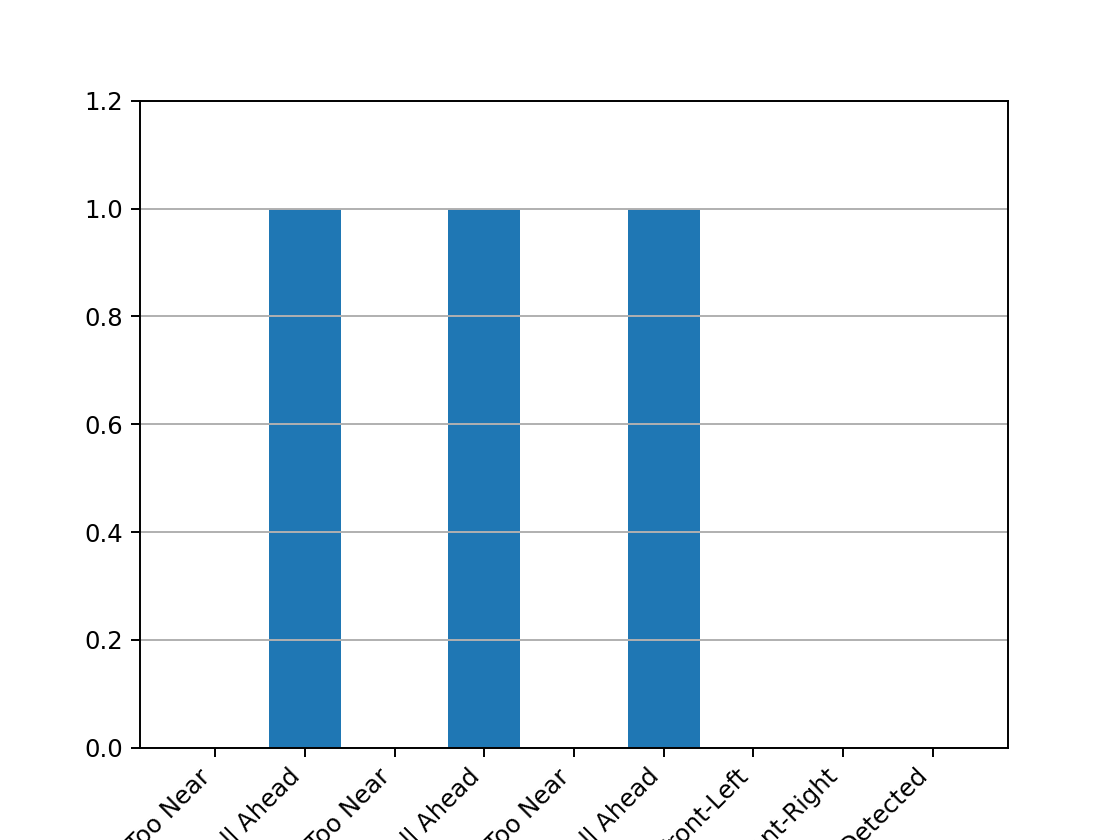

KeyboardInterrupt: 

In [10]:
%matplotlib notebook

import time
import matplotlib.pyplot as plt
import numpy as np

fe = FeatureExtractor(
    near_threshold=0.3,
    wall_threshold=1.5,
    max_range=env.max_range,
    min_range=env.min_range
)


plt.ion()
fig, ax = plt.subplots()

labels = [
    'Front Too Near', 'Front Wall Ahead',
    'Left Too Near', 'Left Wall Ahead',
    'Right Too Near', 'Right Wall Ahead',
    'Corner Front-Left', 'Corner Front-Right',
    'Pillar Detected'
]

from IPython.display import clear_output

'''
while True:
    env.spin_n(1)
    features_detected = fe.extract_features(env.scans)
    
    clear_output(wait=True)
    plt.bar(labels, features_detected)
    plt.ylim(0, 1.2)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.show()
    time.sleep(0.2)

'''
bars = ax.bar(labels, np.zeros(len(labels)))
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.2)
plt.grid(axis='y')

while True:
    env.spin_n(1)
    features_detected = fe.extract_features(env.scans)
    
    for bar, val in zip(bars, features_detected):
        bar.set_height(val)
    
    fig.canvas.draw_idle()  # <<< better for Jupyter
    plt.pause(0.01)         # <<< critical for realtime update


In [ ]:
#def s_(self):
#    return self.feature_extractor.extract_features(self.scans)


Model 2: Either policy gradient or value-based with non-linear function approximation

I have also provided you with the ability to easily create a simple, fully connected neural network in the nnMRP class. You do not need to do a lot; the size of the input dictates the choice between a CNN-based model and a fully connected neural network. You may use either in your project, but using a traditional network, not a CNN, is easier and less time-consuming. The CNN-based one is for learning from the pixels of an input image; we are just using the laser reading in our project.



I’ve also made slight changes to rl.rl.py to enable storing and retrieving an object (via pickle), which can be useful in case of unexpected crashes—something not uncommon in robotics.

Please ensure you download turtlebot3.zip as well to guarantee the environment runs smoothly without any missing files. If you run into any issues, feel free to reach out.

# References

- Núñez, P., Vazquez-Martin, R., Bandera, A., and Romero-Gonzalez, C. (2015) ‘Feature extraction from laser scan data based on curvature estimation for mobile robotics’, *Robotics and Autonomous Systems*, 70, pp. 103–114. Available at: [https://robolab.unex.es/wp-content/papercite-data/pdf/feature-extraction-from-laser.pdf](https://robolab.unex.es/wp-content/publicaciones/2006/Nunez%20Trujillo,%20Vazquez-Martin,%20del%20Toro,%20Bandera%20%7C%20Feature%20extraction%20from%20laser%20scan%20data%20based%20on%20curvature%20estimation%20for%20mobile%20robotics.pdf) (Accessed: 26 April 2025).

- Ramos, J., Rocha, R., and Dias, J. (2022) ‘Efficient approach for extracting high-level B-spline features from laser scan data’, *Sensors*, 22(24), 9737. Available at: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9737135/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9737135/) (Accessed: 26 April 2025).

- Shen, S., Michael, N., and Kumar, V. (2012) ‘Method for corner feature extraction from laser scan data’, *ResearchGate*. Available at: [https://www.researchgate.net/publication/288577925_Method_for_corner_feature_extraction_from_laser_scan_data](https://www.researchgate.net/publication/288577925_Method_for_corner_feature_extraction_from_laser_scan_data) (Accessed: 26 April 2025).

- Stack Overflow (2019) ‘How can I detect the corner from 2D point cloud or LiDAR scanned data?’, *Stack Overflow*. Available at: [https://stackoverflow.com/questions/59049990/how-can-i-detect-the-corner-from-2d-point-cloud-or-lidar-scanned-data](https://stackoverflow.com/questions/59049990/how-can-i-detect-the-corner-from-2d-point-cloud-or-lidar-scanned-data) (Accessed: 26 April 2025).


- CETI. (n.d.) *Simulation Speed in ROS/Gazebo*. Available at: [https://ceti.pages.st.inf.tu-dresden.de/robotics/howtos/SimulationSpeed.html](https://ceti.pages.st.inf.tu-dresden.de/robotics/howtos/SimulationSpeed.html) (Accessed: 26 April 2025).

- Furrer, F., Wermelinger, M., Naegeli, T., et al. (2021) ‘Dynamics and Control of Quadrotor UAVs: A Survey’, *IEEE Transactions on Robotics*, 37(5), pp. 1381–1400. Available at: [https://ieeexplore.ieee.org/document/9453594](https://ieeexplore.ieee.org/document/9453594) (Accessed: 26 April 2025).

- Perez-Perez, J., Jimenez, F. and Mata, M. (2023) ‘An Overview of Reinforcement Learning in Autonomous Driving: Fundamentals, Challenges, and Applications’, *Applied Sciences*, 13(12), p. 7202. Available at: [https://www.mdpi.com/2076-3417/13/12/7202](https://www.mdpi.com/2076-3417/13/12/7202) (Accessed: 26 April 2025).


# Appendicies

## Cool links / interesting reading: 
- https://github.com/hello-robot/stretch_ros/blob/master/stretch_funmap/README.md
- https://arxiv.org/pdf/2502.20607

## Miscelaneous Notes

### Setting up ROS
- https://emanual.robotis.com/docs/en/platform/turtlebot3/sbc_setup/
- https://ros2-industrial-workshop.readthedocs.io/en/latest/_source/navigation/ROS2-Turtlebot.html
- https://emanual.robotis.com/docs/en/platform/turtlebot3/navigation/
- https://emanual.robotis.com/docs/en/platform/turtlebot3/bringup/#bringup

### Multicast traffic (for DDS) through Windows FW to WSL2:
- https://eprosima-dds-router.readthedocs.io/en/latest/rst/examples/repeater_example.html#execute-example
- New-NetFirewallRule -Name 'WSL' -DisplayName 'WSL' -InterfaceAlias 'vEthernet (WSL (Hyper-V firewall))' -Direction Inbound -Action Allow
- New-NetIPAddress -InterfaceAlias 'vEthernet (WSL (Hyper-V firewall))' -IPAddress '192.168.1.217' -PrefixLength 24
- https://github.com/DanielBryars/multicast-test.git

### VM
- https://labs.azure.com/virtualmachines?feature_vnext=true